# Klasifikasi Retakan Permukaan Beton Guna Dalam Pemeliharaan Infrastruktur

## Import Library

In [1]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

Cell code diatas digunakan untuk mengimport library untuk digunankan dalam melakukan spesifikasi citra. Hal ini dilakukan untuk memudahkan pengerjaan dalam membaca dan memproses dataset program serta melakukan proses dengan menggunakan code dalam programnya

## Load Gambar

In [2]:
data = []
labels = []
file_name = []

# Tentukan 3 label folder yang ingin dimuat
allowed_labels = ['label1', 'label2', 'label3']

# Loop hanya pada folder yang termasuk dalam allowed_labels
for sub_folder in os.listdir("dataset\\"):
    if sub_folder not in allowed_labels:
        continue  # Lewati folder yang tidak termasuk

    sub_folder_path = os.path.join("dataset\\", sub_folder)
    sub_folder_files = os.listdir(sub_folder_path)

    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join(sub_folder_path, filename)
        img = cv.imread(img_path)

        if img is None:
            continue  # Lewati file yang gagal diabaca

        img = img.astype(np.uint8)
        data.append(img)
        labels.append(sub_folder)
        file_name.append(filename)
        
print(f"Total gambar berhasil dimuat: {len(data)}")
print(f"Total label yang dimuat: {len(labels)}")


data = np.array(data)
labels = np.array(labels)

Total gambar berhasil dimuat: 600
Total label yang dimuat: 600


cell code ini bertujuan untuk memuat gambar dari folder dataset yang hanya memiliki label tertentu, yaitu `label1`, `label2`, dan `label3`. Program ini pertama-tama mempersiapkan tiga list kosong untuk menyimpan data gambar (data), labelnya (labels), dan nama file gambarnya `(file_name)`. Kemudian, kode memeriksa setiap subfolder di direktori dataset\\ dan hanya melanjutkan proses jika nama folder tersebut termasuk dalam daftar `allowed_labels`. Setiap file dalam folder yang valid akan dibaca menggunakan OpenCV `(cv.imread)`, dan jika pembacaan gambar berhasil, gambar tersebut dikonversi ke tipe data `np.uint8`, lalu disimpan ke dalam `list data`, sementara nama foldernya sebagai label dimasukkan ke `labels`, dan nama filenya ke `file_name`. Setelah semua gambar yang sesuai berhasil dimuat, jumlah total gambar dan label ditampilkan, lalu list data dan labels dikonversi menjadi array NumPy untuk keperluan pemrosesan data lebih lanjut.

## Data Understanding

### Distribusi Data per Label

Cell code dibawah digunakan untuk mendistribusikan data dengan beberapa cara, cara pertama adalah dengan cara menampilkan distribusi data menggunakan grafik batang dan melihat beberapa jumlah data per label

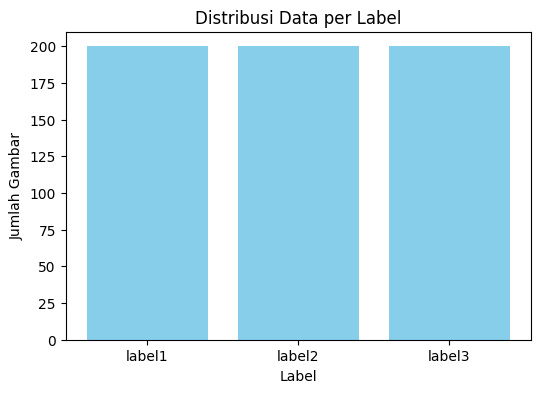

Label: label1, Jumlah: 200
Label: label2, Jumlah: 200
Label: label3, Jumlah: 200


In [3]:
# 1. Distribusi Data per Label
unique, counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(6,4))
plt.bar(unique, counts, color='skyblue')
plt.title("Distribusi Data per Label")
plt.xlabel("Label")
plt.ylabel("Jumlah Gambar")
plt.show()

for u, c in zip(unique, counts):
    print(f"Label: {u}, Jumlah: {c}")

### Menampilkan Sampel Data dari Setiap Label

Cell code ini digunakan untuk menampilkan sampel data dari setiap label yang mana setiap label akan dipilih gambar random dari tiap label dan akan ditampilkan

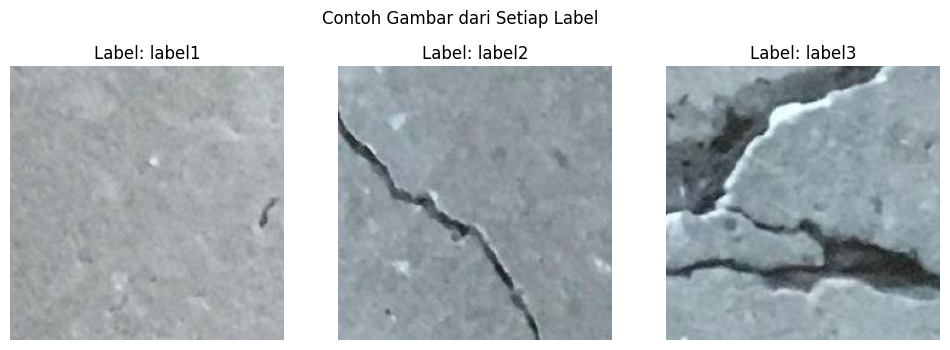

In [4]:
# 2. Menampilkan Sampel Data dari Setiap Label
plt.figure(figsize=(12,4))
for idx, label in enumerate(unique):
    idx_sample = np.where(labels == label)[0][0]
    plt.subplot(1, len(unique), idx+1)
    plt.imshow(data[idx_sample], cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
plt.suptitle("Contoh Gambar dari Setiap Label")
plt.show()

### Statistik Dasar dari Gambar

In [5]:
# 3. Statistik Dasar Gambar
print("Ukuran gambar:", data[0].shape)
print("Nilai pixel min:", np.min(data), "max:", np.max(data), "mean:", np.mean(data))

Ukuran gambar: (227, 227, 3)
Nilai pixel min: 0 max: 255 mean: 166.0229590780596


Cell code ini digunakan untuk mengambil jumlah nilai pixel dari setiap data dan menampilkan hasil mean atau rata ratanya. Hal ini digunakan untuk menvalidasi bahawa dataset memiliki kualitas yang baik dan tidak ada gambar yang rusak atau tidak sesuai

### Distribusi Brightness Gambar

Cell code ini digunakan untuk mencari rata rata distribusi brihghtness gambar dari tiap data pada tiap label. Hal ini digunakan untuk eksplorasi data agar memastikan kualitas dataset dan memilih teknik preprocessing yang baik

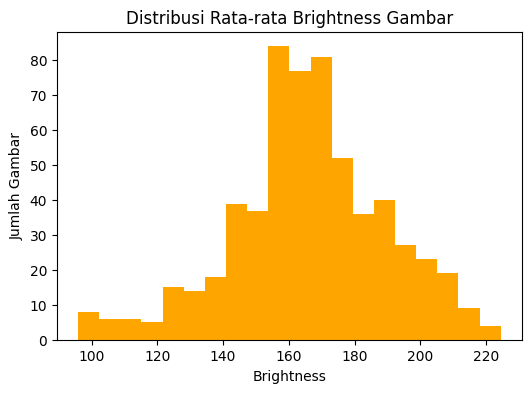

In [6]:
# 4. Distribusi Brightness
brightness = [np.mean(img) for img in data]
plt.figure(figsize=(6,4))
plt.hist(brightness, bins=20, color='orange')
plt.title("Distribusi Rata-rata Brightness Gambar")
plt.xlabel("Brightness")
plt.ylabel("Jumlah Gambar")
plt.show()

## Data Preparation

### Menentukan Function Preprocessing

Kode ini terdiri dari dua fungsi untuk memproses citra secara manual. Fungsi `grayscaling_manual` mengubah citra berwarna (RGB) menjadi citra grayscale dengan menggunakan rumus standar: 0.114 untuk channel biru, 0.587 untuk hijau, dan 0.299 untuk merah—yang mencerminkan kontribusi masing-masing channel terhadap persepsi kecerahan manusia. Hasil konversi ini kemudian dikembalikan dalam bentuk array bertipe uint8. Selanjutnya, fungsi `threshold_image` digunakan untuk melakukan thresholding biner pada citra grayscale dengan membandingkan setiap piksel terhadap nilai ambang (`threshold_value`). Jika nilai piksel lebih besar dari ambang, maka diatur menjadi 0 (hitam), sedangkan jika lebih kecil atau sama, diatur menjadi 255 (putih). Ini menghasilkan citra hitam-putih yang menyoroti bagian gelap dari gambar asli. Nilai threshold yang digunakan dalam contoh ini adalah 110.

In [7]:
def grayscaling_manual(img):
    b, g, r = img[:,:,0], img[:,:,1], img[:,:,2]
    gray = 0.114 * b + 0.587 * g + 0.299 * r
    return gray.astype(np.uint8)


def threshold_image(image, threshold_value):
    thresholded_image = np.zeros(image.shape, dtype=np.uint8)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i, j] > threshold_value:
                thresholded_image[i, j] = 0
            else:
                thresholded_image[i, j] = 255
    return thresholded_image
threshold_value = 110

### Menerapkan Fungsi Preprocessing

Kode ini melakukan preprocessing gambar dalam dua tahap. Pertama, setiap gambar diubah menjadi grayscale dengan `grayscaling_manual` berdasarkan intensitas warna. Kedua, hasil grayscale diberi threshold menggunakan `threshold_image` dengan nilai ambang tertentu, menghasilkan citra biner (hitam-putih). Gambar yang telah diproses disimpan dalam `dataPreprocessed`, lalu dikonversi ke array NumPy untuk keperluan analisis selanjutnya.

In [8]:
dataPreprocessed = []
for i in range(len(data)):
    img = data[i]
    gray = grayscaling_manual(img)
    thres = threshold_image(gray, threshold_value)
    dataPreprocessed.append(thres)
dataPreprocessed = np.array(dataPreprocessed)

### Menampilkan Preview Gambar

Kode ini menampilkan 5 gambar hasil preprocessing (grayscale dan thresholding) untuk setiap label dalam dataset. Dengan `np.unique`, diambil label unik, lalu dibuat subplot dengan baris sebanyak jumlah label dan 5 kolom. Untuk tiap label, ditampilkan hingga 5 gambar pertama menggunakan `imshow` dengan colormap grayscale. Jika kurang dari 5 gambar, subplot sisanya dikosongkan. Judul tiap gambar menampilkan label dan nama file, dan layout dirapikan dengan `plt.tight_layout()`.

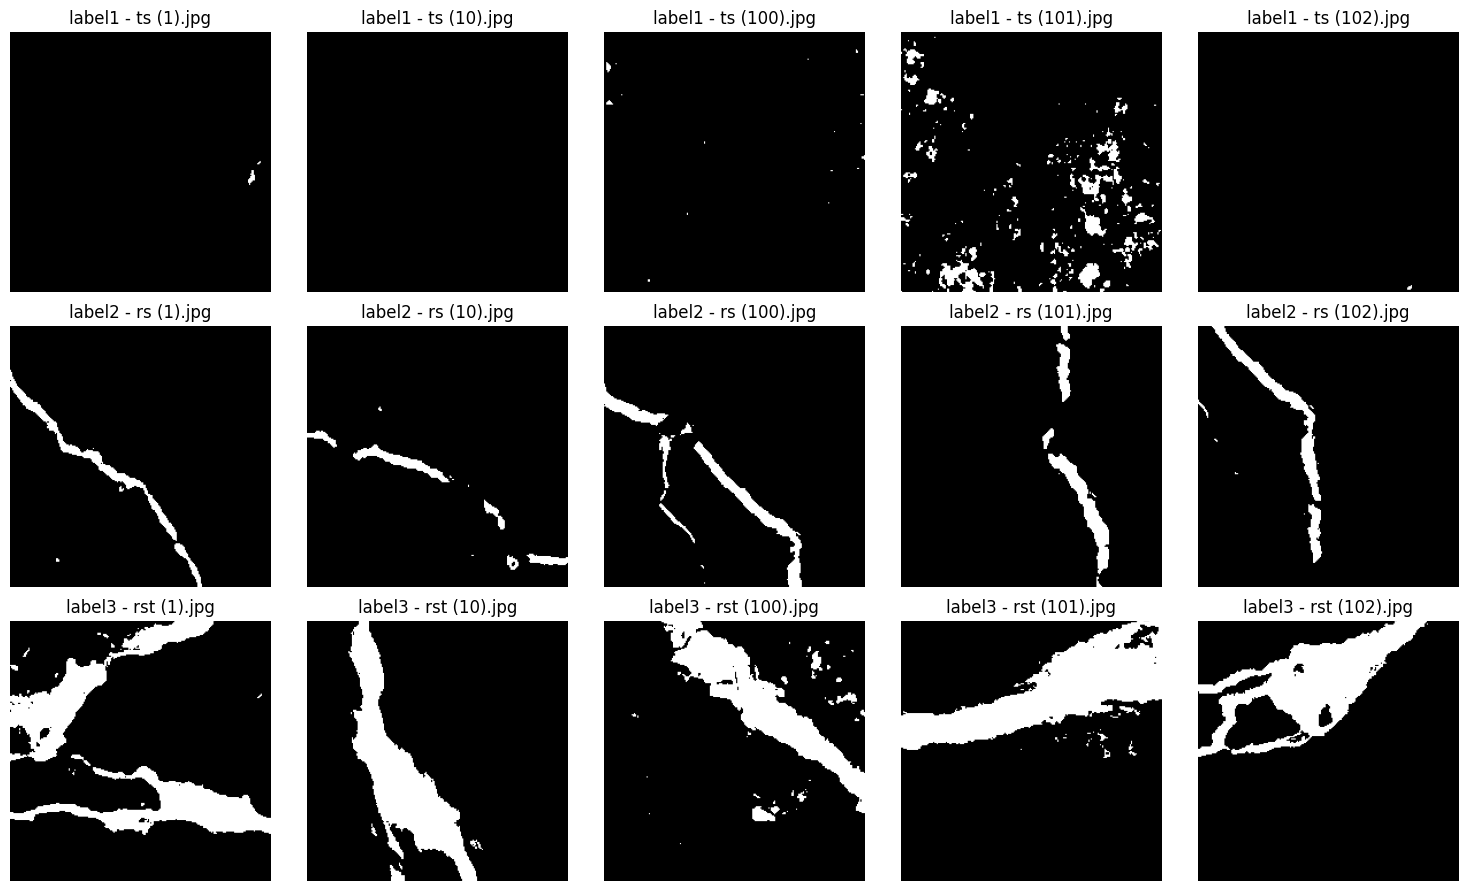

In [9]:
labels_unique = np.unique(labels)
fig, axs = plt.subplots(len(labels_unique), 5, figsize=(15, 3 * len(labels_unique)))

for i, label in enumerate(labels_unique):
    idx = np.where(labels == label)[0][:5]  # Ambil 5 indeks pertama untuk label ini
    if len(idx) == 0:
        for j in range(5):
            axs[i, j].axis('off')
        continue
    for j in range(5):
        if j < len(idx):
            k = idx[j]
            axs[i, j].imshow(dataPreprocessed[k], cmap='gray')
            axs[i, j].set_title(f"{label} - {file_name[k]}")
            axs[i, j].axis('off')
        else:
            axs[i, j].axis('off')

plt.tight_layout()
plt.show()

## Feature Extraction

In [10]:
def glcm(img, derajat):
    if derajat == 0:
        angle = [0]
    elif derajat == 45:
        angle = [np.pi/4]
    elif derajat == 90:
        angle = [np.pi/2]
    elif derajat == 135:
        angle = [3*np.pi/4]
    else:
        raise ValueError("Derajat harus 0, 45, 90, atau 135")
    
    glcm_matrix = graycomatrix(img, [1], angle, 256, symmetric=True, normed=True)
    return glcm_matrix

Fungsi glcm dalam cell code diatas digunakan untuk menghitung matriks Gray Level Co-occurrence Matrix (GLCM) dari citra grayscale, yaitu representasi statistik tekstur berdasarkan kemunculan pasangan nilai piksel dengan jarak dan arah tertentu. Fungsi menerima dua parameter: `img` (citra grayscale) dan `derajat` (arah dalam derajat: 0, 45, 90, atau 135). Berdasarkan nilai derajat, fungsi mengonversi arah tersebut ke dalam satuan radian yang sesuai untuk digunakan oleh fungsi `graycomatrix` dari library `skimage.feature`. Fungsi `graycomatrix` menghitung GLCM dengan jarak 1 piksel dan arah tertentu, dengan jumlah level intensitas 256 (0–255), serta opsi `symmetric=True` untuk menghasilkan matriks simetris dan `normed=True` untuk menormalkan nilai sehingga totalnya 1. Hasilnya adalah sebuah array 4D berisi matriks GLCM yang bisa digunakan untuk ekstraksi fitur tekstur seperti kontras, homogenitas, dan entropi

In [11]:
def correlation(matrix):
    return graycoprops(matrix, 'correlation')[0, 0]
def dissimilarity(matrix):
    return graycoprops(matrix, 'dissimilarity')[0, 0]
def homogeneity(matrix):
    return graycoprops(matrix, 'homogeneity')[0, 0]
def contrast(matrix):
    return graycoprops(matrix, 'contrast')[0, 0]
def ASM(matrix):
    return graycoprops(matrix, 'ASM')[0, 0]
def energy(matrix):
    return graycoprops(matrix, 'energy')[0, 0]
def entropyGLCM(matrix):
    return entropy(matrix.ravel())

Cell code diatas adalah Kumpulan fungsi ini digunakan untuk mengekstraksi fitur tekstur dari matriks GLCM (Gray Level Co-occurrence Matrix) menggunakan fungsi `graycoprops` dari library `skimage.feature`, kecuali untuk entropi. Masing-masing fungsi mengambil input berupa matriks GLCM dan mengembalikan satu nilai fitur tekstur: 
1. `correlation` mengukur hubungan linear antar piksel yang berdekatan. 
2. `dissimilarity` mengukur seberapa berbeda nilai piksel dalam pasangan (semakin besar perbedaan semakin tinggi nilainya).
3. `homogeneity` mengukur keseragaman citra (semakin dekat ke diagonal GLCM, semakin tinggi nilainya)
4. `contrast` menunjukkan perbedaan lokal (nilai tinggi untuk tepi atau tekstur kasar)
5. `ASM` (Angular Second Moment) adalah ukuran ketertiban atau keseragaman citra
energy adalah akar kuadrat dari ASM dan menggambarkan keseragaman secara langsung. 

Sementara itu, `entropyGLCM` menggunakan fungsi entropy dari `scipy.stats`, yang menghitung entropi sebagai ukuran ketidakteraturan dari GLCM setelah diratakan menjadi satu dimensi menggunakan `ravel()`, sehingga mencerminkan kompleksitas tekstur pada gambar.

In [12]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Cell code diatas ini digunakan untuk menghitung matriks GLCM dari setiap gambar dalam `dataPreprocessed` pada empat arah berbeda: 0°, 45°, 90°, dan 135°. Untuk setiap gambar, fungsi glcm dipanggil empat kali sesuai derajat yang ditentukan, lalu hasil GLCM dari masing-masing arah disimpan ke dalam list terpisah: `Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135`. Pendekatan ini memungkinkan analisis tekstur gambar dari berbagai arah, karena karakteristik tekstur bisa berbeda tergantung arah orientasinya.

In [13]:
Kon0, Kon45, Kon90, Kon135 = [], [], [], []
homo0, homo45, homo90, homo135 = [], [], [], []
diss0, diss45, diss90, diss135 = [], [], [], []
entr0, entr45, entr90, entr135 = [], [], [], []
ASM0, ASM45, ASM90, ASM135 = [], [], [], []
energy0, energy45, energy90, energy135 = [], [], [], []
corr0, corr45, corr90, corr135 = [], [], [], []

Cell code diatas ini menyiapkan beberapa list kosong untuk menyimpan nilai-nilai fitur tekstur dari setiap derajat arah GLCM (0°, 45°, 90°, dan 135°). Masing-masing fitur—seperti `Kon` (kontras), `homo` (homogenitas), `diss` (dissimilarity), `entr` (entropi), `ASM` (angular second moment), `energy`, dan `corr` (korelasi)—memiliki empat list sesuai arah, sehingga total ada 28 list yang akan diisi nantinya. Struktur ini dirancang agar setiap fitur tekstur dari semua gambar dapat dikumpulkan dan dianalisis berdasarkan arah perhitungannya, karena arah dapat memengaruhi hasil fitur terutama pada tekstur yang memiliki pola tertentu. Dengan pemisahan ini, analisis fitur tekstur dapat dilakukan secara lebih terarah dan mendalam, baik untuk pembandingan antar fitur maupun antar arah.

In [14]:
for i in range(len(dataPreprocessed)):
    # Sudut 0
    D0 = Derajat0[i]
    Kon0.append(contrast(D0))
    diss0.append(dissimilarity(D0))
    homo0.append(homogeneity(D0))
    entr0.append(entropyGLCM(D0))
    ASM0.append(ASM(D0))
    energy0.append(energy(D0))
    corr0.append(correlation(D0))

Cell code diatas ini melakukan ekstraksi fitur tekstur dari matriks GLCM arah 0° untuk setiap gambar yang sudah dipreproses. Pada setiap iterasi, matriks GLCM pada derajat 0° diambil dari list Derajat0, kemudian berbagai fitur seperti kontras, dissimilarity, homogenitas, entropi, ASM, energi, dan korelasi dihitung menggunakan fungsi-fungsi yang sudah didefinisikan sebelumnya. Nilai fitur tersebut kemudian disimpan secara berurutan ke list masing-masing (`Kon0`, `diss0`, `homo0`, `entro0` dan seterusnya) untuk kemudian dianalisis lebih lanjut

In [15]:
for i in range(len(dataPreprocessed)):
    # Sudut 45
    D45 = Derajat45[i]
    Kon45.append(contrast(D45))
    diss45.append(dissimilarity(D45))
    homo45.append(homogeneity(D45))
    entr45.append(entropyGLCM(D45))
    ASM45.append(ASM(D45))
    energy45.append(energy(D45))
    corr45.append(correlation(D45))

Cell code diatas ini digunakan untuk mengekstraksi fitur tekstur dari matriks GLCM (Gray Level Co-occurrence Matrix) pada sudut 45° untuk setiap gambar yang telah dipreproses. Pada setiap iterasi, matriks GLCM untuk sudut 45° diambil dari list `Derajat45`, lalu berbagai fitur tekstur seperti kontras (`contrast`), dissimilarity (`dissimilarity`), homogenitas (`homogeneity`), entropi (`entropyGLCM`), Angular Second Moment (`ASM`), energi (`energy`), dan korelasi (`correlation`) dihitung menggunakan fungsi-fungsi yang telah didefinisikan sebelumnya. Hasil perhitungan fitur ini disimpan ke dalam list masing-masing (`Kon45`, `diss45`, `homo45`, dll.) untuk dianalisis lebih lanjut.

In [16]:
for i in range(len(dataPreprocessed)):
    # Sudut 90
    D90 = Derajat90[i]
    Kon90.append(contrast(D90))
    diss90.append(dissimilarity(D90))
    homo90.append(homogeneity(D90))
    entr90.append(entropyGLCM(D90))
    ASM90.append(ASM(D90))
    energy90.append(energy(D90))
    corr90.append(correlation(D90))

Cell code diatas ini mengekstrak fitur-fitur tekstur dari matriks GLCM pada arah 90° untuk setiap gambar yang telah melalui preprocessing. Setiap iterasi mengambil matriks GLCM 90° dari list `Derajat90` untuk menghitung 7 karakteristik tekstur penting yaitu kontras, dissimilarity, homogenitas, entropi, ASM, energi, dan korelasi menggunakan fungsi-fungsi predefined. Setiap nilai perhitungan karakteristik tersebut disimpan dalam list terpisah (`Kon90`, `diss90`, `homo90`, dll) untuk keperluan analisis selanjutnya.

In [17]:
for i in range(len(dataPreprocessed)):
    # Sudut 135
    D135 = Derajat135[i]
    Kon135.append(contrast(D135))
    diss135.append(dissimilarity(D135))
    homo135.append(homogeneity(D135))
    entr135.append(entropyGLCM(D135))
    ASM135.append(ASM(D135))
    energy135.append(energy(D135))
    corr135.append(correlation(D135))

Cell code diatas ini melakukan ekstraksi fitur tekstur dari matriks GLCM pada sudut 135° untuk setiap gambar yang telah diproses. Dalam setiap iterasi, matriks GLCM diambil dari list `Derajat135`, lalu dihitung 7 fitur tekstur penting yaitu kontras (mengukur perbedaan intensitas), dissimilarity (mengukur ketidaksamaan), homogenitas (mengukur keseragaman), entropi (mengukur ketidakteraturan), ASM (mengukur keteraturan), energi (mengukur keseragaman), dan korelasi (mengukur ketergantungan linear) menggunakan fungsi yang telah didefinisikan sebelumnya. Hasil perhitungan masing-masing fitur disimpan ke dalam list terpisah (`Kon135`, `diss135`, `homo135`, dll.) untuk digunakan dalam analisis tekstur citra selanjutnya.

## Hasil Ekstraksi ke CSV

In [18]:
dataTable = {
    'Filename': file_name, 'Label': labels,
    'Contrast0': Kon0, 'Contrast45': Kon45, 'Contrast90': Kon90, 'Contrast135': Kon135,
    'Homogeneity0': homo0, 'Homogeneity45': homo45, 'Homogeneity90': homo90, 'Homogeneity135': homo135,
    'Dissimilarity0': diss0, 'Dissimilarity45': diss45, 'Dissimilarity90': diss90, 'Dissimilarity135': diss135,
    'Entropy0': entr0, 'Entropy45': entr45, 'Entropy90': entr90, 'Entropy135': entr135,
    'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
    'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
    'Correlation0': corr0, 'Correlation45': corr45, 'Correlation90': corr90, 'Correlation135': corr135,
}
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak

,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,ts (1).jpg,label1,40.559822,53.470319,25.349889,35.646879,0.999376,0.999178,0.999610,0.999452,...,0.997858,0.997692,0.998811,0.998708,0.998928,0.998845,0.644132,0.532922,0.777583,0.688615
1,ts (10).jpg,label1,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,ts (100).jpg,label1,83.654633,101.848226,81.119644,112.033049,0.998714,0.998434,0.998753,0.998277,...,0.995912,0.995504,0.997973,0.997828,0.997954,0.997749,0.534567,0.435835,0.561019,0.379419
3,ts (101).jpg,label1,2360.074656,3012.161289,2139.530623,3059.266094,0.963706,0.953678,0.967097,0.952953,...,0.838655,0.825229,0.913836,0.908792,0.915781,0.908421,0.720652,0.643448,0.745969,0.637919
4,ts (102).jpg,label1,10.139956,17.823440,10.139956,10.184823,0.999844,0.999726,0.999844,0.999843,...,0.999415,0.999413,0.999708,0.999648,0.999708,0.999706,0.636286,0.363499,0.636286,0.636285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,rst (95).jpg,label3,537.417645,803.327884,670.504561,861.890614,0.991735,0.987646,0.989689,0.986745,...,0.791074,0.788040,0.890645,0.888210,0.889424,0.887716,0.958375,0.937882,0.948111,0.933353
596,rst (96).jpg,label3,673.039550,995.566411,1000.053117,1362.220025,0.989650,0.984690,0.984621,0.979051,...,0.718524,0.713177,0.850089,0.847709,0.847658,0.844498,0.961249,0.942509,0.942255,0.921336
597,rst (97).jpg,label3,656.562122,1341.850380,986.110678,1005.751233,0.989903,0.979364,0.984835,0.984533,...,0.644329,0.644009,0.806360,0.799392,0.802701,0.802502,0.970284,0.939442,0.955493,0.954610
598,rst (98).jpg,label3,778.241589,1355.854511,1012.728061,1152.158059,0.988032,0.979149,0.984426,0.982282,...,0.773490,0.770997,0.881466,0.876348,0.879483,0.878064,0.943330,0.901458,0.926250,0.916262


Cell code ini menggabungkan seluruh hasil ekstraksi fitur tekstur dari gambar ke dalam bentuk tabel yang terstruktur. Dictionary `dataTable` dibentuk dengan pasangan key-value, di mana key adalah nama kolom seperti `'Filename'` untuk nama file gambar, `'Label'` untuk kategori atau kelas gambar, dan sisanya adalah fitur-fitur tekstur seperti `'Contrast'`, `'Homogeneity'`, `'Dissimilarity'`, `'Entropy'`, `'ASM'`, `'Energy'`, dan `'Correlation'` yang masing-masing dihitung dari arah GLCM 0°, 45°, 90°, dan 135°. Setiap list nilai fitur tersebut sebelumnya sudah diisi melalui proses perhitungan untuk semua gambar, sehingga panjang setiap list sama dan merepresentasikan gambar dalam urutan yang sama. Setelah itu, dictionary ini dikonversi menjadi objek DataFrame dengan `pd.DataFrame(dataTable)`, yang merupakan struktur data tabular dari pustaka pandas. DataFrame ini disimpan ke dalam file CSV bernama `hasil_ekstraksi_(...).csv` menggunakan `to_csv`, tanpa menyertakan kolom indeks karena `index=False`. Langkah ini penting agar hasil ekstraksi dapat disimpan secara permanen dan digunakan kembali tanpa harus mengulang proses ekstraksi dari awal. Terakhir, file CSV dibaca kembali ke dalam DataFrame `hasilEkstrak` dengan `pd.read_csv`, sehingga seluruh data siap untuk analisis lanjutan seperti visualisasi, seleksi fitur, atau pelatihan model machine learning

## Feature Selection

### Menggunakan ANOVA

In [19]:
from sklearn.feature_selection import SelectKBest, f_classif

# Pisahkan fitur dan label
X = hasilEkstrak.drop(columns=['Filename', 'Label'])
y = hasilEkstrak['Label']

# Pilih 10 fitur terbaik dengan ANOVA F-test
selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X, y)

# Tampilkan nama fitur terpilih
selected_features = X.columns[selector.get_support()]
print("Fitur terbaik hasil seleksi ANOVA:", list(selected_features))

# Jika ingin DataFrame hasil seleksi:
df_selected = hasilEkstrak[selected_features]
df_selected['Label'] = y
df_selected.head()

Fitur terbaik hasil seleksi ANOVA: ['Entropy0', 'Entropy45', 'Entropy90', 'Entropy135', 'ASM0', 'ASM45', 'ASM90', 'ASM135', 'Energy0', 'Energy90']


C:\Users\ASUS\AppData\Local\Temp\ipykernel_8152\3596497498.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['Label'] = y


,Entropy0,Entropy45,Entropy90,Entropy135,ASM0,ASM45,ASM90,ASM135,Energy0,Energy90,Label
0,0.010451,0.011303,0.009376,0.010146,0.997624,0.997418,0.997858,0.997692,0.998811,0.998928,label1
1,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,label1
2,0.016819,0.017869,0.016951,0.018396,0.995951,0.995660,0.995912,0.995504,0.997973,0.997954,label1
3,0.382652,0.405991,0.373377,0.407595,0.835095,0.825903,0.838655,0.825229,0.913836,0.915781,label1
4,0.002982,0.003531,0.002982,0.002994,0.999415,0.999295,0.999415,0.999413,0.999708,0.999708,label1


Cell code diatas ini melakukan seleksi fitur pada data hasil ekstraksi tekstur dengan menggunakan metode ANOVA F-test melalui fungsi `SelectKBest` dari library `sklearn.feature_selection`. Pertama, fitur (`X`) diambil dari DataFrame `hasilEkstrak` dengan menghapus kolom `'Filename'` dan `'Label'`, sedangkan label kelas disimpan dalam variabel `y`. Kemudian, `SelectKBest` digunakan untuk memilih 10 fitur terbaik yang paling relevan terhadap label menggunakan skor ANOVA F (dengan `f_classif`). Setelah fitur terbaik dipilih, nama-nama kolomnya diambil menggunakan `get_support()` dan ditampilkan. Terakhir, DataFrame baru bernama `df_selected` dibuat hanya dengan fitur-fitur terpilih ditambah kolom `'Label'`, yang kemudian bisa digunakan untuk pelatihan model klasifikasi dengan fitur yang lebih optimal dan ringkas.

## Splitting Data

In [20]:
X = df_selected.drop(columns=['Label'])
y = df_selected['Label']

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Jumlah data train:", len(X_train))
print("Jumlah data test:", len(X_test))

Jumlah data train: 480
Jumlah data test: 120


Cell code ini melakukan pembagian (splitting) dataset menjadi data latih dan data uji. Pertama, variabel X dibuat dengan menghapus kolom `'Label'` dari `df_selected` untuk mendapatkan fitur-fitur, sementara variabel `y` berisi label kelas dari dataset. Kemudian menggunakan fungsi `train_test_split` untuk membagi data dengan proporsi 80% data latih (`X_train`, `y_train`) dan 20% data uji (`X_test`, `y_test`). Parameter `random_state=42` digunakan untuk memastikan hasil pembagian yang konsisten setiap kali kode dijalankan, sedangkan `stratify=y` memastikan proporsi kelas dalam data latih dan uji tetap seimbang sesuai distribusi aslinya.

## Feature Normalization

### Menggunakan Standardization

In [21]:
scaler = StandardScaler()
# Fit scaler pada data training, lalu transform data training dan testing
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

X_train_scaled shape: (480, 10)
X_test_scaled shape: (120, 10)


Kode ini melakukan normalisasi data menggunakan `StandardScaler` dari `sklearn`. Pertama, objek `scaler` dibuat untuk melakukan standardisasi. Kemudian `fit_transform()` digunakan pada data latih (`X_train`) untuk menghitung mean dan standar deviasi sekaligus mentransformasi data, menghasilkan `X_train_scaled`. Untuk data uji, hanya dilakukan `transform()` menggunakan parameter yang sudah dihitung dari data latih, menghasilkan `X_test_scaled`. Hal ini penting untuk menghindari data leakage. Standardisasi membuat fitur-fitur memiliki mean=0 dan standar deviasi=1, yang membantu model machine learning bekerja lebih optimal. Terakhir, dimensi data yang telah dinormalisasi ditampilkan untuk verifikasi.

## Modeling

### Define Model

In [22]:
def generateClassificationReport(y_true, y_pred):
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))
    print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

Kode ini mendefinisikan fungsi `generateClassificationReport` dan inisialisasi 3 model klasifikasi yang berbeda. Fungsi tersebut dibuat untuk menampilkan laporan evaluasi model dengan parameter input `y_true` (label asli) dan `y_pred` (label hasil prediksi), yang akan menampilkan classification report (metrik precision, recall, f1-score), confusion matrix (matriks prediksi benar/salah), dan accuracy score (persentase ketepatan prediksi). Selanjutnya, kode menginisialisasi 3 model machine learning: Random Forest (`rf`) dengan 5 pohon keputusan, Support Vector Machine (`svm`) dengan kernel RBF, dan K-Nearest Neighbors (`knn`) dengan 5 tetangga terdekat. Setiap model menggunakan `random_state=42` untuk memastikan hasil yang konsisten pada setiap eksekusi.

### Train Random Forest Classifier

In [23]:
# Train Random Forest Classifier
rf.fit(X_train_scaled, y_train)

# Make predictions and evaluate the model with the training set
print("------Random Forest: Training Set------")
y_pred = rf.predict(X_train_scaled)
generateClassificationReport(y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Random Forest: Testing Set------")
y_pred = rf.predict(X_test_scaled)
generateClassificationReport(y_test, y_pred)

------Random Forest: Training Set------
              precision    recall  f1-score   support

      label1       0.99      0.99      0.99       160
      label2       0.95      0.98      0.97       160
      label3       0.99      0.96      0.97       160

    accuracy                           0.98       480
   macro avg       0.98      0.98      0.98       480
weighted avg       0.98      0.98      0.98       480

[[158   2   0]
 [  1 157   2]
 [  0   6 154]]
Accuracy: 0.9770833333333333

------Random Forest: Testing Set------
              precision    recall  f1-score   support

      label1       1.00      0.93      0.96        40
      label2       0.88      0.95      0.92        40
      label3       0.93      0.93      0.93        40

    accuracy                           0.93       120
   macro avg       0.94      0.93      0.93       120
weighted avg       0.94      0.93      0.93       120

[[37  2  1]
 [ 0 38  2]
 [ 0  3 37]]
Accuracy: 0.9333333333333333


Cell code diatas ini melakukan pelatihan dan evaluasi model Random Forest. Pertama, model dilatih menggunakan `rf.fit()` dengan data latih yang telah dinormalisasi (`X_train_scaled`) dan labelnya (`y_train`). Kemudian dilakukan evaluasi pada dua set data: data latih dan data uji. Untuk setiap set, model melakukan prediksi menggunakan `rf.predict()` dan hasilnya dievaluasi menggunakan fungsi `generateClassificationReport()` yang telah didefinisikan sebelumnya. Fungsi ini akan menampilkan classification report, confusion matrix, dan accuracy score untuk menilai performa model. Evaluasi pada data latih menunjukkan seberapa baik model mempelajari pola data, sementara evaluasi pada data uji menunjukkan kemampuan generalisasi model terhadap data baru.

### Train SVM Classifier

In [24]:
# Train SVM Classifier
svm.fit(X_train_scaled, y_train)

# Make predictions and evaluate the model with the training set
print("\n------SVM: Training Set------")
y_pred = svm.predict(X_train_scaled)
generateClassificationReport(y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------SVM: Testing Set------")
y_pred = svm.predict(X_test_scaled)
generateClassificationReport(y_test, y_pred)


------SVM: Training Set------
              precision    recall  f1-score   support

      label1       0.96      0.97      0.96       160
      label2       0.89      0.89      0.89       160
      label3       0.92      0.91      0.92       160

    accuracy                           0.92       480
   macro avg       0.92      0.92      0.92       480
weighted avg       0.92      0.92      0.92       480

[[155   3   2]
 [  7 142  11]
 [  0  14 146]]
Accuracy: 0.9229166666666667

------SVM: Testing Set------
              precision    recall  f1-score   support

      label1       1.00      0.97      0.99        40
      label2       0.93      0.97      0.95        40
      label3       0.95      0.93      0.94        40

    accuracy                           0.96       120
   macro avg       0.96      0.96      0.96       120
weighted avg       0.96      0.96      0.96       120

[[39  0  1]
 [ 0 39  1]
 [ 0  3 37]]
Accuracy: 0.9583333333333334


Kode ini melakukan pelatihan dan evaluasi model Support Vector Machine (SVM). Pertama, model SVM dilatih dengan `svm.fit()` menggunakan data latih yang telah dinormalisasi (`X_train_scaled`) dan labelnya (`y_train`). Selanjutnya, dilakukan evaluasi pada dua set data: data latih dan data uji. Pada setiap set, model melakukan prediksi dengan `svm.predict()` dan hasilnya dievaluasi menggunakan fungsi `generateClassificationReport()`. Fungsi ini menampilkan classification report (metrik performa), confusion matrix (matriks prediksi), dan accuracy score (skor akurasi). Evaluasi pada data latih menunjukkan kemampuan model dalam memahami pola data, sedangkan evaluasi pada data uji menunjukkan seberapa baik model dapat melakukan generalisasi pada data yang belum pernah dilihat.

### Train KNN Classifier

In [25]:
# Train KNN Classifier
knn.fit(X_train_scaled, y_train)

# Make predictions and evaluate the model with the training set
print("\n------KNN: Training Set------")
y_pred = knn.predict(X_train_scaled)
generateClassificationReport(y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------KNN: Testing Set------")
y_pred = knn.predict(X_test_scaled)
generateClassificationReport(y_test, y_pred)


------KNN: Training Set------
              precision    recall  f1-score   support

      label1       0.97      0.96      0.97       160
      label2       0.90      0.93      0.91       160
      label3       0.94      0.93      0.94       160

    accuracy                           0.94       480
   macro avg       0.94      0.94      0.94       480
weighted avg       0.94      0.94      0.94       480

[[154   5   1]
 [  4 148   8]
 [  0  11 149]]
Accuracy: 0.9395833333333333

------KNN: Testing Set------
              precision    recall  f1-score   support

      label1       1.00      0.97      0.99        40
      label2       0.93      0.97      0.95        40
      label3       0.95      0.93      0.94        40

    accuracy                           0.96       120
   macro avg       0.96      0.96      0.96       120
weighted avg       0.96      0.96      0.96       120

[[39  0  1]
 [ 0 39  1]
 [ 0  3 37]]
Accuracy: 0.9583333333333334


Kode ini melakukan pelatihan dan evaluasi model K-Nearest Neighbors (KNN). Pertama, model dilatih menggunakan `knn.fit()` dengan data latih yang telah dinormalisasi (`X_train_scaled`) dan labelnya (`y_train`). Kemudian dilakukan evaluasi pada dua set data: data latih dan data uji. Untuk setiap set data, model melakukan prediksi dengan `knn.predict()` dan hasilnya dievaluasi menggunakan fungsi `generateClassificationReport()`. Fungsi ini menampilkan classification report (metrik performa), confusion matrix (matriks prediksi), dan accuracy score (skor akurasi). Evaluasi pada data latih menunjukkan seberapa baik model dapat memahami pola data, sementara evaluasi pada data uji menunjukkan kemampuan model dalam melakukan generalisasi terhadap data yang belum pernah dilihat sebelumnya.

## Evaluation With Confusion Matrix

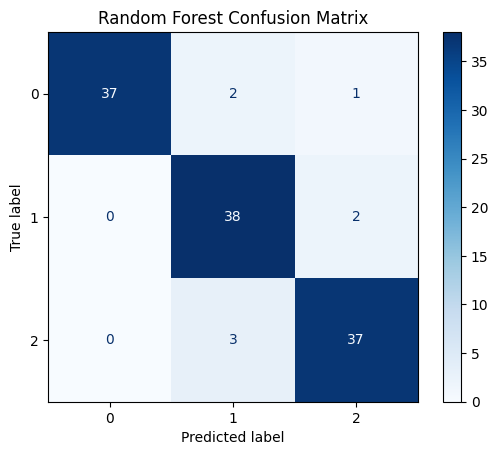

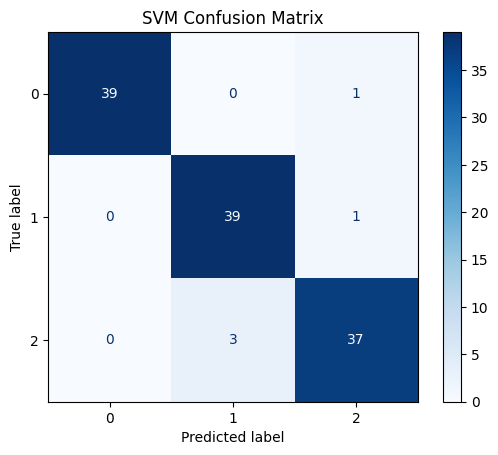

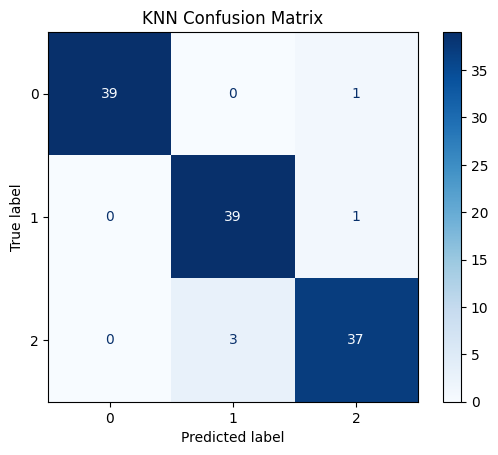

In [26]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test_scaled), "Random Forest Confusion Matrix")

# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test_scaled), "SVM Confusion Matrix")

# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test_scaled), "KNN Confusion Matrix")

Kode ini berfungsi untuk menampilkan confusion matrix (matriks kebingungan) dari hasil prediksi tiga model klasifikasi berbeda: Random Forest, Support Vector Machine (SVM), dan K-Nearest Neighbors (KNN). Fungsi `plot_confusion_matrix` pertama-tama menerima dua parameter utama, yaitu label sebenarnya (`y_true`) dan hasil prediksi model (`y_pred`), serta `title` untuk memberi judul pada plot. Di dalam fungsi, `confusion_matrix()` digunakan untuk menghitung matriks perbandingan antara label sebenarnya dan label prediksi, lalu divisualisasikan menggunakan `ConfusionMatrixDisplay`, yang akan menggambarkan jumlah prediksi benar dan salah dalam bentuk tabel dua dimensi dengan skema warna biru (`plt.cm.Blues`) untuk memperjelas nilai intensitas. Fungsi ini kemudian dipanggil tiga kali untuk masing-masing model (Random Forest, SVM, dan KNN), menggunakan data pengujian `X_test_scaled` dan label sebenarnya `y_test`, sehingga setiap model akan menghasilkan satu confusion matrix sebagai hasil evaluasi performa.

Untuk memahami hasil dari visualisasi ini, perlu memperhatikan angka-angka di dalam matriks—khususnya nilai diagonal dari kiri atas ke kanan bawah, yang menunjukkan jumlah prediksi yang tepat (benar). Semakin besar angka di diagonal, artinya semakin banyak data yang diklasifikasikan dengan benar. Sebaliknya, angka di luar diagonal menunjukkan kesalahan klasifikasi, yakni ketika model salah menebak label kelas. Sebagai contoh, jika sebuah gambar sebenarnya berlabel "label1" namun diprediksi sebagai "label2", maka nilainya akan muncul di baris "label1" dan kolom "label2". Dengan membandingkan ketiga matriks dari Random Forest, SVM, dan KNN, kamu bisa mengevaluasi model mana yang paling akurat, model mana yang sering melakukan kesalahan terhadap kelas tertentu, dan apakah ada pola tertentu dalam kesalahan prediksi